# Imports

In [1]:
import collections
import math
import os
import random
import torch
import matplotlib.pyplot as plt
from torch import nn
import time
import numpy as np
import re

# Sentiment Analysis

## Preprocessing the dataset

In [4]:
def read_imdb(data_dir, is_train):
    data, labels = [], []
    for label in ['pos', 'neg']:
        folder_name = os.path.join(data_dir, 'train' if is_train else 'test', label)
        for file in os.listdir(folder_name):
            with open(os.path.join(folder_name, file), 'r', encoding='utf-8') as f:
                review = f.read().replace('\n', '')
                data.append(review)
                labels.append(1 if label == 'pos' else 0)
    return data, labels

In [6]:
train_data = read_imdb('aclImdb', True)
print('# training: ', len(train_data[0]))
for x, y in zip(train_data[0][:3], train_data[1][:3]):
    print('label: ', y, 'review: ', x[:60])

# training:  25000
label:  1 review:  Bromwell High is a cartoon comedy. It ran at the same time a
label:  1 review:  Homelessness (or Houselessness as George Carlin stated) has 
label:  1 review:  Brilliant over-acting by Lesley Ann Warren. Best dramatic ho


In [9]:
def preprocess(text):
    return re.sub('[^A-Za-z]+', ' ', text).lower()
class Vocab:
    """Vocabulary for text."""
    def __init__(self, tokens=[], min_freq=0, reserved_tokens=[]):
        """Defined in :numref:`sec_text-sequence`"""
        # Flatten a 2D list if needed
        if tokens and isinstance(tokens[0], list):
            tokens = [token for line in tokens for token in line]
        # Count token frequencies
        counter = collections.Counter(tokens)
        self.token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                  reverse=True)
        # The list of unique tokens
        self.idx_to_token = list(sorted(set(['<unk>'] + reserved_tokens + [
            token for token, freq in self.token_freqs if freq >= min_freq])))
        self.token_to_idx = {token: idx
                             for idx, token in enumerate(self.idx_to_token)}

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if hasattr(indices, '__len__') and len(indices) > 1:
            return [self.idx_to_token[int(index)] for index in indices]
        return self.idx_to_token[indices]

    @property
    def unk(self):  # Index for the unknown token
        return self.token_to_idx['<unk>']
    
def tokenize(lines, token='word'):
    """Split text lines into word or character tokens.

    Defined in :numref:`sec_text_preprocessing`"""
    if token == 'word':
        return [line.split() for line in lines]
    elif token == 'char':
        return [list(line) for line in lines]
    else:
        print('ERROR: unknown token type: ' + token)

def build(raw_text, vocab=None):
    tokens = tokenize(preprocess(raw_text))
    if vocab is None: vocab = Vocab(tokens)
    corpus = [vocab[token] for token in tokens]
    return corpus, vocab


In [10]:
train_tokens = tokenize(train_data[0], token='word')
vocab = Vocab(train_tokens, min_freq=5, reserved_tokens=['<pad>'])

(array([ 553., 2373., 6820., 4834., 2817., 1848., 1380., 1005.,  759.,
         581.,  437.,  349.,  257.,  207.,  174.,  133.,  116.,   85.,
          75.]),
 array([  0.,  50., 100., 150., 200., 250., 300., 350., 400., 450., 500.,
        550., 600., 650., 700., 750., 800., 850., 900., 950.]),
 <BarContainer object of 19 artists>)

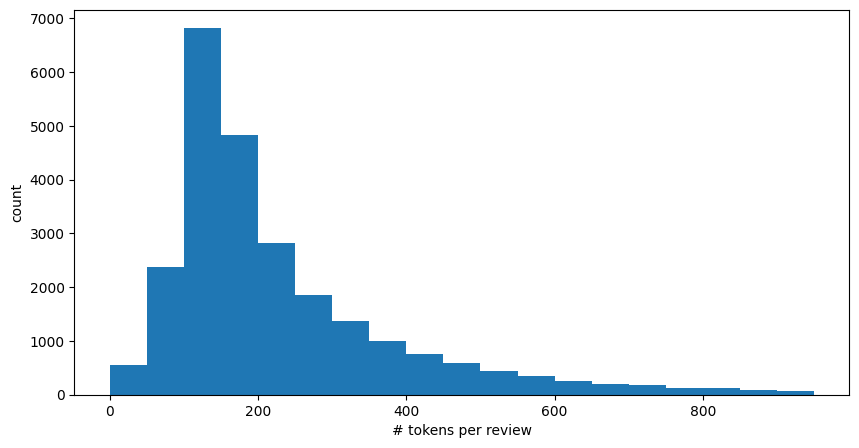

In [11]:
plt.figure(figsize=(10, 5))
plt.xlabel('# tokens per review')
plt.ylabel('count')
plt.hist([len(line) for line in train_tokens], bins=range(0, 1000, 50))

In [12]:
def truncate_pad(line, num_steps, padding_token):
    """Truncate or pad sequences."""
    if len(line) > num_steps:
        return line[:num_steps]  # Truncate
    return line + [padding_token] * (num_steps - len(line))

In [13]:
#Sequence length
num_steps = 500
train_features = torch.tensor([truncate_pad(vocab[line], num_steps, vocab['<pad>']) for line in train_tokens])

In [14]:
print(train_features.shape)

torch.Size([25000, 500])


## Creating Data Iterators

In [19]:
def load_array(data_arrays, batch_size, is_train=True):
    """Construct a PyTorch data iterator."""
    dataset = torch.utils.data.TensorDataset(*data_arrays)
    return torch.utils.data.DataLoader(dataset, batch_size, shuffle=is_train)

In [20]:
train_iter = load_array((train_features, torch.tensor(train_data[1])), batch_size=64, is_train=True)

for X, y in train_iter:
    print('X:', X.shape, 'y:', y.shape)
    break
print('# batches: ', len(train_iter))

X: torch.Size([64, 500]) y: torch.Size([64])
# batches:  391


# Putting it all together

In [21]:
def load_data_imdb(batch_size, num_steps=500):
    data_dir = "aclImdb"
    train_data = read_imdb(data_dir, True)
    test_data = read_imdb(data_dir, False)
    train_tokens = tokenize(train_data[0], token='word')
    test_tokens = tokenize(test_data[0], token='word')
    vocab = Vocab(train_tokens, min_freq=5)
    train_features = torch.tensor([truncate_pad(vocab[line], num_steps, vocab['<pad>']) for line in train_tokens])
    test_features = torch.tensor([truncate_pad(vocab[line], num_steps, vocab['<pad>']) for line in test_tokens])
    train_iter = load_array((train_features, torch.tensor(train_data[1])), batch_size, is_train=True)
    test_iter = load_array((test_features, torch.tensor(test_data[1])), batch_size, is_train=False)
    return train_iter, test_iter, vocab

train_iter, test_iter, vocab = load_data_imdb(64, 500)

# Sentiment Analysis Using RNNs

## Representing Single Text with RNNs